In [5]:
# import modules
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import wkt
from shapely.geometry import Point
import shapely
import osmnx as ox
import pandas as pd
import networkx as nx
from shapely.geometry import LineString
from tabulate import tabulate
import math as math
from geojson import Feature, LineString, FeatureCollection



In [95]:
# Reading csv files into panda DataFrames
dfNodes = pd.read_csv("/mnt/c/users/kriso/documents/itu/5th_semester/research_project/CoolWalk/data/CoolWalksDataStorge/nodes.csv")
dfEdges = pd.read_csv("/mnt/c/users/kriso/documents/itu/5th_semester/research_project/CoolWalk/data/CoolWalksDataStorge/edges.csv")

In [7]:
#Testing stuff. Not necessary to execute
geopint = dfNodes['geopoint']
#print(geopint)

In [51]:
#Testing stuff. Not necessary to execute
x = gpd.GeoSeries.from_wkt(dfNodes['geopoint']) #This exact function (with the exact same input) does not work for some reason when run in python file. (It ran several times previously without problems...)

In [74]:
#Testing stuff. Not necessary to execute
#creating the shadow fraction column separately
shadow_fraction_column = (dfEdges['shadowed_length'] / dfEdges['full_length'])
#print(shadow_fraction_column.notnull())

In [287]:
#creating shadow fraction column in the Edges dataframe
dfEdges['shadow_fraction'] = (dfEdges['shadowed_length'] / dfEdges['full_length'])

In [288]:
#Testing. Not necessary to run
# displaying shadow_fraction column of the new Edges dataframe, and checking that they are not all NaN. Display the new shadow_fraction column consisting only of the rows where its value os not na
shadow_fraction_column = dfEdges.loc[dfEdges['shadow_fraction'].notnull()]['shadow_fraction']

#print(shadow_fraction_column)
#print(shadow_fraction_column.dtypes)

In [109]:
#Just a check. Not necessary to run

# Print Nodes dataframe with helper nodes. Prints the nodes dataframe consisting only of rows where value of osm_id column == 0
helper_nodes = dfNodes.loc[dfNodes['osm_id'] == 0]

#print(tabulate(helper_nodes, headers='keys', tablefmt='psql'))


In [77]:
##Just a check. Not necessary to run 

# Print Edges dataframe with helper edges. Prints the edges dataframe consisting only of rows where value of helper column ==True
helper_edges = dfEdges.loc[dfEdges['helper'] == True]

#print(tabulate(helper_edges, headers='keys', tablefmt='psql'))

In [108]:
##Testing

# Find and display edges with NaN-valued 'shadowed_part_length' row instances. Displaying the shadowed_part_length column, consisting only of the rows where its value os IS na/null
shadowed_part_length_column_NaNs = dfEdges.loc[dfEdges['shadowed_part_length'].isna()]['shadowed_part_length']

# Find and displaying shadowed_part_length column of the new Edges dataframe, and checking that they are not all NaN. Display the shadowed_part_length column consisting only of the rows where its value os NOT na/null
shadowed_part_length_column_not_NaNs = dfEdges.loc[dfEdges['shadowed_part_length'].notnull()]['shadowed_part_length']

#print(shadowed_part_length_column_NaNs)

In [107]:
##Testing

# Find and display edges with NaN-valued 'full_length' row instances. Displaying the full_length column, consisting only of the rows where its value os IS na/null
full_length_column_NaNs = dfEdges.loc[dfEdges['full_length'].isna()]['full_length']

full_length_column_not_NaNs = dfEdges.loc[dfEdges['full_length'].notnull()]['full_length']

print(full_length_column_NaNs)

Series([], Name: full_length, dtype: float64)


In [6]:
##Testing 

# Display Get the average shadowed_part_length value, to replace missing shadowed_part_length values
average_shadowed_part_length = dfEdges['shadowed_part_length'].mean()

print(average_shadowed_part_length)

25.67922929481338


In [114]:
#Dont execute

#TODO If shadow is None it is 0. However, our current cost-function is not compatible with this, since it is a division, and will thus result in division by 0 errors.
#   TEMPORARY SOLUTION: Dont execute this cell. Let the shortest_path_algorithm fill out the None shadow values with 1. 

#Find and replace all None-valued 'shadowed_part_length' instances in edges with 0
dfEdges['shadowed_part_length'] = dfEdges['shadowed_part_length'].fillna(0)

In [96]:
# Find and replace all None-valued 'full_length' instances in edges with the average full_length value
dfEdges['full_length'] = dfEdges['full_length'].fillna(dfEdges['full_length'].mean())

In [143]:
#TESTING. Not necessary to execute
    # Checking that helper node with vertex_id=25262 can be found in the nodes before removing helpers
    #print(dfNodes.loc[dfNodes['vertex_id'] == 25262])

       osm_id        lat geopoint  vertex_id    end       lon helper
25261       0  52.942779      NaN      25262  False -1.229999   True


In [97]:
# Find and discard helper nodes from dfNodes. Helper nodes do not have a 'geopoint' attribute value in the dataframe
dfNodes.drop(dfNodes[dfNodes.osm_id == 0].index, inplace=True)
#print(tabulate(gdfNodes, headers='keys', tablefmt='psql'))

In [145]:
#TESTING. Not necessary to execute
    # Checking that helper node with vertex_id=25262 has been removed 
    # print(dfNodes.loc[dfNodes['vertex_id'] == 25262])

Empty DataFrame
Columns: [osm_id, lat, geopoint, vertex_id, end, lon, helper]
Index: []


In [98]:
# Find and discard helper edges from gdfEdges
dfEdges.drop(dfEdges[dfEdges.helper == True].index, inplace=True)
#print(tabulate(gdfEdges, headers='keys', tablefmt='psql'))

In [99]:
# Setting osmid as index for nodes (mutating the dataframe). ATTENTION! the osmnx code will create the x_lookup and y_lookup dictionaries based on the index of the nodes data frame. That is, the keys of these dictionaries will consist
# of the values of the index column, and the values will be the lon(x_lookup) and lat(y_lookup) values respectively   

dfNodes.set_index('vertex_id', inplace=True) 
#dfNodes.set_index('osm_id', inplace=True) 



#Printing dataframes in readable format
#print(tabulate(gdfNodes, headers='keys', tablefmt='psql'))

In [100]:
#setting src_id, dst_id and osm_id of edge geodf´s as the multiindex(u, v, key) of each node (mutating the dataframe)
dfEdges.set_index(['src_id','dst_id','osm_id'], inplace=True) #should we use the osm_id from the Nodes instead, since Henrik says they have 0 values to indicate multi-edges, which is what the value 'k' is intended for in the documentation of utils_graph.graph_from_gdfs

#Printing dataframes in readable format
#print(tabulate(gdfEdges, headers='keys', tablefmt='psql'))

In [101]:
# Transforming relevant columns of DataFrames into GeoSeries to be used as geometry column of GeoDataFrames
dfNodes['geopoint'] = gpd.GeoSeries.from_wkt(dfNodes['geopoint'])
dfEdges['edgegeom'] = gpd.GeoSeries.from_wkt(dfEdges['edgegeom'])

In [102]:
# Defining GeoDataFrames with GeoSeries columns from above
gdfNodes = gpd.GeoDataFrame(dfNodes, geometry='geopoint', crs="EPSG:27700")
gdfEdges = gpd.GeoDataFrame(dfEdges, geometry='edgegeom', crs="EPSG:27700")

In [103]:
# Data wrangling: Editing/andjustment GeoDataFrames
gdfNodes.rename(columns = {'lat':'x', 'lon':'y'}, inplace = True)
gdfNodes["x"] = gdfNodes["geopoint"].x
gdfNodes["y"] = gdfNodes["geopoint"].y

#print(tabulate(gdfNodes, headers='keys', tablefmt='psql'))



In [104]:
G = ox.utils_graph.graph_from_gdfs(gdfNodes, gdfEdges, graph_attrs=None)


In [108]:
G.is_multigraph()

True

In [17]:
def weigth_function_original(u, v, d):
    assert len(list(attr.get('full_length', 1) for attr in d.values())) == 1 #the graph only have one sttribute with name = 'full_length'
    dict = list(d.values())[0].get('full_length')  # w could perhaps also just access full_length and shadowed_length in this way?
    if dict is not None : #apparently some edges does not have a 'full_length' attribute, and in that case the attribute value will be none. check in the data frame for none values
        print(dict)
    full_length = min(attr.get('full_length', 1) for attr in d.values()) #if 'full_length' value is None, then it will default to 1... keyError will return None because we use the get() method
    shadow_length = min(attr.get('shadowed_length', 1) for attr in d.values())
    result = full_length/shadow_length # we get many 1´s, which either because they default to 1, or because shadow_length==full_length(very unlikely). So in the next line, we filter out all the 1´s to make sure that we actually have real meaningfull values
    if not math.isclose(result, 1): #
        print(result)
    return result

In [112]:
def weight_function_1(u, v, d):
    #print(d.values())
    assert len(list(attr.get('full_length', 0) for attr in d.values())) == 1 #the graph only have one sttribute with name = 'full_length'
    dict = list(d.values())[0].get('full_length')  # w could perhaps also just access full_length and shadowed_length in this way?
    #if dict is not None : #apparently some edges does not have a 'full_length' attribute, and in that case the attribute value will be none. check in the data frame for none values
    #    print(dict)
    full_length = min(attr.get('full_length', 0) for attr in d.values()) #if 'full_length' value is None, then it will default to 1... keyError will return None because we use the get() method
    shadow_length = min(attr.get('shadowed_part_length', 0) for attr in d.values())
    result = (shadow_length/full_length) + (full_length/shadow_length) # we get many 1´s, which either because they default to 1, or because shadow_length==full_length(very unlikely). So in the next line, we filter out all the 1´s to make sure that we actually have real meaningfull values
    #if not math.isclose(result, 1): #
    #    print(result)
    return result

In [111]:
def weight_function_2(u, v, d):
    #print(d.values())
    assert len(list(attr.get('full_length', 0) for attr in d.values())) == 1 #the graph only have one sttribute with name = 'full_length'
    dict = list(d.values())[0].get('full_length')  # w could perhaps also just access full_length and shadowed_length in this way?
    #if dict is not None : #apparently some edges does not have a 'full_length' attribute, and in that case the attribute value will be none. check in the data frame for none values
    #    print(dict)
    full_length = min(attr.get('full_length', 0) for attr in d.values()) #if 'full_length' value is None, then it will default to 1... keyError will return None because we use the get() method
    shadow_length = min(attr.get('shadowed_part_length', 0) for attr in d.values())
    sunny_length = full_length-shadow_length
    result = (full_length*0.8) + (sunny_length*1.2) # Applying statistical weights to sunny length and full length
    #if not math.isclose(result, 1): #
    #    print(result)

    print("full_length = ",end='') 
    print(full_length)
    print("shadow_length = ",end='')
    print(shadow_length)
    print("sunny_length = ", end='')
    print(sunny_length)
    print("result = ",end='')
    print(result)

    return result

In [52]:
optimal_path_test1 = nx.shortest_path(G, source=9, target=15987, weight=weight_function_1)

dict_values([{'geomlength': 0, 'edgegeom': <shapely.geometry.linestring.LineString object at 0x7f2347ca90c0>, 'full_length': 83.28501899060669}])
83.28501899060669
83.29702595190801
dict_values([{'geomlength': 0, 'edgegeom': <shapely.geometry.linestring.LineString object at 0x7f2347ca9120>, 'full_length': 83.28501899060669}])
83.28501899060669
83.29702595190801
dict_values([{'geomlength': 0, 'edgegeom': <shapely.geometry.linestring.LineString object at 0x7f2347ca9180>, 'full_length': 83.28501899060669}])
83.28501899060669
83.29702595190801
dict_values([{'geomlength': 0, 'edgegeom': <shapely.geometry.linestring.LineString object at 0x7f2347ca91e0>, 'full_length': 83.28501899060669}])
83.28501899060669
83.29702595190801
dict_values([{'geomlength': 0, 'edgegeom': <shapely.geometry.linestring.LineString object at 0x7f234762b580>, 'full_length': 83.28501899060669}])
83.28501899060669
83.29702595190801
dict_values([{'geomlength': 0, 'edgegeom': <shapely.geometry.linestring.LineString object 

In [46]:
regular_shortest_path = nx.shortest_path(G, source=9, target=15987, weight='full_length')

In [51]:
#check if path is simple
print(nx.is_simple_path(G,nx.shortest_path(G, source=9, target=15987, weight='full_length')))

True


In [35]:
# A way to iterate through a Python generator object
        #count = 0
        #for item in simple_paths_within_range_generator:
        #    if count>1: 
        #        break
        #    print(item)
        #    count+=1

In [199]:
# Graph inspection. Display the NodeDataView of the graph

# G.nodes.data(True)

In [183]:
# Graph inspection. Display the MultiEdgeDataView of the graph

# G.edges.data(True)

In [111]:
# Extracting the columns and attributes of the edges of the Graph (Code stolen from osmnx/utils_graph.py:66)

u, v, k, data = zip(*G.edges(keys=True, data=True)) # u=edges.scr_id-->nodes.vertex_id, v=edges.dst_id-->nodes.vertex_id, k=edges.osm_id, data=edges._attribute_columns

# print(type(u)) # edges.src_id, type=tuple... The values of this tuple each represents the source node of a given edge(edges.src_id), and corresponds to a 'vertex_id'-value in the nodes data(nodes.vertex_id). However, the osmnx, and Folium libraries expect it to correspond to an osm id(nodes.osm_id) 
# print(type(v)) # edges.dst_id, type=tuple... The values of this tuple each represents the destination node of a given edge(edges.dst_id), and corresponds to a 'vertex_id'-value in the nodes data(nodes.vertex_id). However, the osmnx, and Folium libraries expect it to correspond to an osm id(nodes.osm_id)

In [178]:
# Graph inspection/extraction

# Extracting the a dictionary with the nodes_index as the key, and the chosen attribute (second argument of the function) as the value

x_lookup = nx.get_node_attributes(G, "x") # type=dict, The keys of this dict corresponds to the osm id (nodes.osm_id) of a given node(nodes.osm_id). Its value corresponds to its lon-value(nodes.lon)
y_lookup = nx.get_node_attributes(G, "y") # type=dict, The keys of this dict corresponds to the osm id (nodes.osm_id) of a given node(nodes.osm_id). Its value corresponds to its lat-value(nodes.lat)

In [232]:
# Graph inspection/extraction

edge_lookup = nx.get_edge_attributes(G, "full_length") # osm_id, scr_id and dst_id required to look up values in this dictionary. Can perhaps be used to verify the full_length values extracted in the benchmark functionality

    # ATTENTION! When expecting the edges dictionaries, like the one above, it seems that there exist an exact duplicate of each edge. At least when expecting the edge dictionary for the shadowed_part_length attribute

    # Example of how provide the index of and edge as the key to look up in the an edge dictionary:
        # edge_lookup[dst_id,src_id,osm_id] ---> e.g. edge_lookup[8983, 15939, 24454558.0])

    # Display the entire dictionary: print(edge_lookup)

In [233]:
print(edge_lookup[8983, 15939, 24454558.0])

9.029045785468297


In [ ]:
#Graph inspection/extraction

# Extracting the attributes of a given edge(u,v) only by providing scr_id and dst_id. The edge data is given as dict. Afterwards specifying which attribute value to get.
edge_data = G.get_edge_data(dst,src) #ATTENTION! 3rd argument of this function is what should be returned in case edge(u,v) is not found. It defaults to a None object, and thus we put this statement i a try statement to handle such a case
#print(edge_data)
try:
     print(min(attr.get('full_length', 0) for attr in edge_data.values())) # Should the value of the specified attribute be None, then the returned value will default to 0
except AttributeError: 
    print("edge with given scr and dst does not exist in data set")

In [81]:
#Graph inspection/extraction

# Extracting the attributes of a given edge(u,v) only by providing scr_id and dst_id. The edge data is given as dict. Afterwards specifying which attribute value to get.
def get_src_dst_distance(src, dst):
     edge_data = G.get_edge_data(src,dst) #ATTENTION! 3rd argument of this function is what should be returned in case edge(u,v) is not found. It defaults to a None object, and thus we put this statement i a try statement to handle such a case
     #print(edge_data)
     try:
          return (min(attr.get('full_length', 0) for attr in edge_data.values())) # Should the value of the specified attribute be None, then the returned value will default to 0
     except AttributeError: 
         print("edge with given scr and dst does not exist in data set")

In [82]:
#Graph inspection/extraction

# Extracting the attributes of a given edge(u,v) only by providing scr_id and dst_id. The edge data is given as dict. Afterwards specifying which attribute value to get.
def get_src_dst_shadowed_distance(src, dst):
     edge_data = G.get_edge_data(src,dst) #ATTENTION! 3rd argument of this function is what should be returned in case edge(u,v) is not found. It defaults to a None object, and thus we put this statement i a try statement to handle such a case
     #print(edge_data)
     try:
          return (min(attr.get('shadowed_part_length', 0) for attr in edge_data.values())) # Should the value of the specified attribute be None, then the returned value will default to 0
     except AttributeError: 
         print("edge with given scr and dst does not exist in data set")

In [231]:
print(edge_data)

{24454558.0: {'geomlength': 0, 'edgegeom': <shapely.geometry.linestring.LineString object at 0x7f063baaeaa0>, 'shadowed_length': 1.75826266407714, 'full_length': 9.029045785468297, 'shadowed_part_length': 1.7582626870419125, 'shadowgeom': 'LINESTRING (-1.25343454071202 52.9090394792746,-1.2534464 52.9090254)'}}


In [24]:
test_list = [9, 21096, 4847, 16077, 13009, 7958, 1809, 13392, 4021, 3745, 24909, 18872]

In [83]:
# Function for getting the total length of a path

def get_total_path_length(path):
    try:
        total_length = 0
        for index,scr in enumerate(path):
            if(index==len(path)-1):
                break
            dst = path[index+1]
            scr_dst_distance = get_src_dst_distance(scr, dst)
            total_length += scr_dst_distance
        return total_length
    except TypeError:
        print("No distance between given scr and dst")


In [37]:
get_total_path_length(optimal_path_test1)

7663.939979643108

In [47]:
get_total_path_length(regular_shortest_path)

7141.679874262998

In [84]:
# Testing

# Function for getting the total length of a path, which is covered by shadow

def get_total_path_shadowed_length(path):
    try:
        total_length = 0
        for index,scr in enumerate(path):
            if(index==len(path)-1):
                break
            dst = path[index+1]
            scr_dst_distance = get_src_dst_shadowed_distance(scr, dst)
            total_length += scr_dst_distance
        return total_length
    except TypeError:
        print("No distance between given scr and dst")


In [41]:
get_total_path_shadowed_length(optimal_path_test1)

414.60203426996935

In [48]:
get_total_path_shadowed_length(regular_shortest_path)

43.468657001834934

In [85]:
# Testing 

# Function for getting the fraction of a path which is covered by shadow

def get_shadowed_part_of_path(path):
    try:
        shadowed_part = get_total_path_shadowed_length(path) / get_total_path_length(path)
        return shadowed_part
    except TypeError:
        print("No distance between given scr and dst")


In [44]:
get_shadowed_part_of_path(optimal_path_test1)

0.05409776634097237

In [49]:
get_shadowed_part_of_path(regular_shortest_path)

0.006086615161579303

In [93]:
#Testing

# Function for benchmarking a cost function against the regular shortst path with 'full_length' as the weight

def cost_function_performance(src, dst, cost_function):
    regular_shortest_path = nx.shortest_path(G, source=src, target=dst, weight='full_length')
    optimized_path = nx.shortest_path(G, source=src, target=dst, weight=cost_function)
    shadowed_part_regular = get_shadowed_part_of_path(regular_shortest_path)
    shadowed_part_optimized = get_shadowed_part_of_path(optimized_path)
    benchmark = shadowed_part_regular
    performance = 100*(shadowed_part_optimized/benchmark)
    print("shadowed_part_regular = ",end='') 
    print(shadowed_part_regular)
    print("shadowed_part_optimized = ",end='')
    print(shadowed_part_optimized)
    print("benchmark = ", end='')
    print(benchmark)
    print("performance = ",end='')
    print(performance)
    return performance


In [105]:
print(cost_function_performance(9,15987, weight_function_1))

shadowed_part_regular = 0.006086615161579303
shadowed_part_optimized = 0.05409776634097237
benchmark = 0.006086615161579303
performance = 888.7988628302818
888.7988628302818


In [113]:
print(cost_function_performance(9,15987, weight_function_2))

full_length = 83.28501899060669
shadow_length = 0
sunny_length = 83.28501899060669
result = 166.57003798121337
full_length = 83.28501899060669
shadow_length = 0
sunny_length = 83.28501899060669
result = 166.57003798121337
full_length = 83.28501899060669
shadow_length = 0
sunny_length = 83.28501899060669
result = 166.57003798121337
full_length = 83.28501899060669
shadow_length = 0
sunny_length = 83.28501899060669
result = 166.57003798121337
full_length = 83.28501899060669
shadow_length = 0
sunny_length = 83.28501899060669
result = 166.57003798121337
full_length = 83.28501899060669
shadow_length = 0
sunny_length = 83.28501899060669
result = 166.57003798121337
full_length = 83.28501899060669
shadow_length = 0
sunny_length = 83.28501899060669
result = 166.57003798121337
full_length = 83.28501899060669
shadow_length = 0
sunny_length = 83.28501899060669
result = 166.57003798121337
full_length = 83.28501899060669
shadow_length = 0
sunny_length = 83.28501899060669
result = 166.57003798121337
f

In [236]:
p_u = Point((x_lookup[15633],y_lookup[15633]))
p_v = Point((x_lookup[1],y_lookup[1]))

In [ ]:
x_lookup[]
y_lookup[]

In [237]:
print(p_u)
print(p_v)

POINT (-1.2338981 52.9724785)
POINT (-1.0771582 53.0405631)


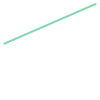

In [238]:
LineString([(-1.2338981,52.9724785),(-1.0771582,53.0405631)])

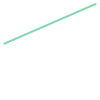

In [239]:
LineString([p_u,p_v])

In [244]:
# Function for extracting the LineString of the shortest path

def get_path_coords(path):
    x_lookup = nx.get_node_attributes(G, "x")
    y_lookup = nx.get_node_attributes(G, "y")
    
    path_nodes_coords = []
    for node in path:
        node_coords = [x_lookup[node],y_lookup[node]]
        path_nodes_coords.append(node_coords)
    return path_nodes_coords

In [245]:
get_path_coords(test)

[[-1.2308052, 52.9172807],
 [-1.2304076, 52.9171913],
 [-1.2311288, 52.9160053],
 [-1.2314551, 52.9154955],
 [-1.2314668, 52.9152939],
 [-1.2310729, 52.915213],
 [-1.2284268, 52.9164818],
 [-1.2267049, 52.9172103],
 [-1.2248307, 52.9179255],
 [-1.2214068, 52.9193248],
 [-1.2185393, 52.920014],
 [-1.2184322, 52.9200247],
 [-1.2175636, 52.920111],
 [-1.216058, 52.9202767],
 [-1.2137707, 52.9206469],
 [-1.2132365, 52.920831],
 [-1.2117095, 52.9215499],
 [-1.2115111, 52.9214377],
 [-1.2112088, 52.9212985],
 [-1.2108346, 52.9211149],
 [-1.2099575, 52.9207701],
 [-1.208986, 52.9214654],
 [-1.2085994, 52.9217407],
 [-1.2084923, 52.9218161],
 [-1.2083243, 52.9217038],
 [-1.2082416, 52.9216461],
 [-1.2064419, 52.9205234],
 [-1.2061567, 52.9203875],
 [-1.2056776, 52.9206189],
 [-1.2043804, 52.9211499],
 [-1.2036076, 52.9216807],
 [-1.2024478, 52.9224943],
 [-1.2019629, 52.9228321],
 [-1.1995821, 52.9236488],
 [-1.1979357, 52.9246375],
 [-1.1976138, 52.9252279],
 [-1.1977492, 52.9252839],
 [-1.19

In [165]:
ox.folium.plot_graph_folium(G)
#REASON FOR FAILING: 
    # Assuming that the 'vertex_id' column has been chosen as the index of the nodes dataframe. The reason for failing is that the LineString computation in osmnx/utils_graph.py:79 fails. The reason this
    # computation fails is that the tuple of edges.src_id´s(u) and the tuple of edges.dst_id´s (v) contains values which corresponds to 'vertex_id'-values of helper nodes. Since helper nodes have been removed, the x_lookup and 
    # y_lookup does not contain vertex_id of these nodes as keys, and thus we get a KeyErro when trying to look them up. Important to note that the edges that have these non-existing helper nodes as either their source or 
    # destination, are not themselves helper-edges. They are real edges which, for some reason, are attached to a non-existing helper node in one of its ends.
    # At first glance, it seems like leaving all helper nodes be in the nodes data framwe when building the graph would be a solution. However, it could seems like either osmnx or networkX removes nodes which has no value for 
    # for their 'geopint' attribute, which is the case for the helper nodes.     

KeyError: 25262